## Named Entity Recognition and Entity Linking (IE 7500)
### SINGH,SUKHVEER, SINGH.SUK@NORTHEASTERN.EDU
### E, AISHWARIYA, E.AI@NORTHEASTERN.EDU
### LOKESH CHOWDHARY, YELLAMANCHALI.L@NORTHEASTERN.EDU

In [1]:
# Downloading and setting up the Environment
import pandas as pd
import nltk
from nltk.corpus import conll2002, conll2000

In [2]:
# Parsing the data from .txt file from conll data set
Training_data = "train.txt"
Testing_data = "test.txt"
Validation_data = "valid.txt"

def data_from_txt(path_of_txt):
    with open(path_of_txt, 'r') as f:
        sentences, tags = [], []
        sentence, tag = [], []
        
        for line in f:
            if line.strip()== '':
                if sentence and tag:
                    sentences.append(sentence)
                    tags.append(tag)
                    sentence, tag = [], []
            else:
                if line.startswith('-DOCSTART-'):
                    continue
                parts = line.strip().split()
                sentence.append(parts[0])
                tag.append(parts[3])
        if sentence and tag:
            sentences.append(sentence)
            tags.append(tag)
    return sentences, tags

train_sen, train_tags = data_from_txt(Training_data)
test_sen, test_tags = data_from_txt(Testing_data)
valid_sen, valid_tags = data_from_txt(Validation_data)



In [3]:
len(valid_sen)

3250

## Implementing NER model, we are going to develop following model:
### 1) NLTK- classifier
### 2) Spacy "en_core_web_sm"
### 3) Tensorflow "LSTM" model

In [4]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from numpy import argmax
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical


2024-04-17 17:08:13.278831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#NLTK's pre-trained classifier

def extract_entities(text):
    sentences = nltk.sent_tokenize(text)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = [ne_chunk(tagged) for tagged in tagged_sentences]
    return chunked_sentences

# Example usage
text = "Google was founded by Larry Page and Sergey Brin while they were students at Stanford University."
Chunked = extract_entities(text)
print(Chunked)

[Tree('S', [Tree('PERSON', [('Google', 'NNP')]), ('was', 'VBD'), ('founded', 'VBN'), ('by', 'IN'), Tree('PERSON', [('Larry', 'NNP'), ('Page', 'NNP')]), ('and', 'CC'), Tree('PERSON', [('Sergey', 'NNP'), ('Brin', 'NNP')]), ('while', 'IN'), ('they', 'PRP'), ('were', 'VBD'), ('students', 'NNS'), ('at', 'IN'), Tree('ORGANIZATION', [('Stanford', 'NNP'), ('University', 'NNP')]), ('.', '.')])]


In [6]:
entities = []
for tree in Chunked:
    for subtree in tree:
        if type(subtree) == nltk.Tree:
           entity_type = subtree.label()
           entity_name = " ".join([token for token, pos in subtree.leaves()])
           entities.append((entity_name, entity_type))
df = pd.DataFrame(entities, columns=['Entity', 'Type'])
print(df)

                Entity          Type
0               Google        PERSON
1           Larry Page        PERSON
2          Sergey Brin        PERSON
3  Stanford University  ORGANIZATION


### Spacy NER model "en_core_web_sm"

In [7]:
#!python3 -m spacy download en_core_web_sm

In [8]:
nlp = spacy.load('en_core_web_sm')

text = "Google was founded by Larry Page and Sergey Brin while they were students at Stanford University."

# Process the text
doc = nlp(text)

entities = [(ent.text, ent.label_) for ent in doc.ents]

df_spacy = pd.DataFrame(entities, columns=['Entity', 'Type'])

# Display the DataFrame
print(df_spacy)


                Entity    Type
0               Google     ORG
1           Larry Page  PERSON
2          Sergey Brin  PERSON
3  Stanford University     ORG


## Training an LSTM model using TensorFlow

In [9]:
# From preprocessing first step we have 
# train_sen, train_tags = data_from_txt(Training_data)
# test_sen, test_tags = data_from_txt(Training_data)
# valid_sen, valid_tags = data_from_txt(Training_data)

In [10]:
# Tokenizing and pad sequencing the dataset for making it easier for Tensorflow Keras to understand
# tokenizing the words
# Putting oov_token so that the Keras will understands the vocabulary words to train
word_tokenizer = Tokenizer(lower=False, oov_token='OOV')
word_tokenizer.fit_on_texts(train_sen)
train_seq = word_tokenizer.texts_to_sequences(train_sen)
test_seq = word_tokenizer.texts_to_sequences(test_sen)
valid_seq = word_tokenizer.texts_to_sequences(valid_sen)

#tokenizing the tags 
tags_tokenizer = Tokenizer(lower=False)
tags_tokenizer.fit_on_texts(train_tags)
train_tagseq = tags_tokenizer.texts_to_sequences(train_tags)
test_tagseq = tags_tokenizer.texts_to_sequences(test_tags)
valid_tagseq = tags_tokenizer.texts_to_sequences(valid_tags)

# Pad sequences for Uniform input size
max_len = max(max(len(s) for s in train_seq), max(len(s) for s in valid_seq), max(len(s) for s in test_seq))
padd_train_seq = pad_sequences(train_seq, maxlen=max_len, padding='post')
padd_test_seq = pad_sequences(test_seq, maxlen=max_len, padding='post')
padd_valid_seq = pad_sequences(valid_seq, maxlen=max_len, padding='post')
padd_train_tag_seq = pad_sequences(train_tagseq, maxlen=max_len, padding='post', value=tags_tokenizer.word_index['O'])
padd_valid_tag_seq = pad_sequences(valid_tagseq, maxlen=max_len, padding='post', value=tags_tokenizer.word_index['O'])
padd_test_tag_seq = pad_sequences(test_tagseq, maxlen=max_len, padding='post', value=tags_tokenizer.word_index['O'])


#### Building LSTM Model

In [11]:
max_seq_length = max_len
Vocab = len(word_tokenizer.word_index) + 1
num_tags = len(tags_tokenizer.word_index) + 1
LSTM_model = Sequential([
    Embedding(input_dim= Vocab , output_dim= 64),
    Bidirectional(LSTM(units= 64, return_sequences=True)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LSTM_model.build(input_shape=(None, max_seq_length))
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 124, 64)        │     1,512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 124, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 124, 10)        │         1,290 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,338 (6.02 MB)

 Trainable params: 1,579,338 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import numpy as np 
LSTM_model.fit(padd_train_seq, np.array(padd_train_tag_seq), 
          batch_size=32, epochs=10, 
          validation_data=(padd_valid_seq, np.array(padd_valid_tag_seq))
         )

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 99s 206ms/step - accuracy: 0.9662 - loss: 0.1918 - val_accuracy: 0.9837 - val_loss: 0.0526
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 96s 218ms/step - accuracy: 0.9882 - loss: 0.0375 - val_accuracy: 0.9921 - val_loss: 0.0288
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 205ms/step - accuracy: 0.9959 - loss: 0.0157 - val_accuracy: 0.9946 - val_loss: 0.0198
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 0.9951 - val_loss: 0.0173
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9952 - val_loss: 0.0171
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9951 - val_loss: 0.0176
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9951 - val_loss: 0.0189
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.9999 - loss: 7.369

In [13]:
LSTM_model.evaluate(padd_test_seq, np.array(padd_test_tag_seq))

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9927 - loss: 0.0293


[0.02794620767235756, 0.9931945204734802]

In [14]:
Pred = LSTM_model.predict(padd_test_seq)
Pred_tags = np.argmax(Pred, axis=1)

predicted_tag_names = []
for sent_pred in Pred_tags:
    tag_names = [tags_tokenizer.index_word.get(i, 'O') for i in sent_pred]
    predicted_tag_names.append(tag_names)

trimmed_predictions = []
for sent_tags, sent_len in zip(predicted_tag_names, [len(sent) for sent in test_sen]):
    trimmed_predictions.append(sent_tags[:sent_len])

df = pd.DataFrame({
    'Sentence': [' '.join(sent) for sent in test_sen],
    'Predicted Tags': [' '.join(tags) for tags in trimmed_predictions]
})

df.head()

108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


,Sentence,Predicted Tags
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...",B-PER O B-MISC B-LOC B-MISC B-ORG B-PER I-MISC...
1,Nadim Ladki,O B-LOC
2,"AL-AIN , United Arab Emirates 1996-12-06",O I-ORG B-LOC O O I-PER
3,Japan began the defence of their Asian Cup tit...,O I-MISC O O O O O I-ORG O B-MISC
4,But China saw their luck desert them in the se...,O B-MISC O O O O B-LOC O O O


## Using the model to predict one article

In [15]:

Article = "Over 500 games and applications feature RTX technologies, and barely a week goes by without an incredible new game integrating NVIDIA DLSS, NVIDIA Reflex, and advanced ray-traced effects to deliver the definitive PC experience for GeForce RTX players. Last week, Outpost: Infinity Siege launched with DLSS 3, Diablo IV added ray-traced effects, and Alone In The Dark and Lightyear Frontier launched with DLSS 2. This week, we’re highlighting the start of Season 3 in Call of Duty®: Modern Warfare® III and Call of Duty: Warzone™, the 1.0 launch of Midnight Ghost Hunt, and Tchia availability on Steam, all enhanced by NVIDIA DLSS. Read on for all the details."

Token = word_tokenizer.texts_to_sequences([Article.split()])
Padded = pad_sequences(Token, maxlen=max_seq_length, padding='post')

prediction = LSTM_model.predict(Padded)
prediction_tags = [tags_tokenizer.index_word[index] for index in np.argmax(prediction, axis=-1)[0]]

sen_length = len(Article.split())
prediction_tags = prediction_tags[:sen_length]

DF_NER = pd.DataFrame({'Tokens': Article.split(), 'Tags': prediction_tags})

DF_NER[100:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,Tokens,Tags
100,NVIDIA,O
101,DLSS.,O
102,Read,O
103,on,O
104,for,O
105,all,O
106,the,O
107,details.,O


## Linking Entities to Wikipedia

In [16]:
DF_NER["Tokens"]

0              Over
1               500
2             games
3               and
4      applications
           ...     
103              on
104             for
105             all
106             the
107        details.
Name: Tokens, Length: 108, dtype: object

In [17]:
import requests
def NER_wikipedia(entities):
    # Initialize session
    session = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    entity_links = []

    # Loop through each entity and get its Wikipedia link
    for entity in entities:
        SEARCH_PARAMS = {
            'action': "query",
            'list': "search",
            'srsearch': entity,
            'format': "json"
        }
        response = session.get(url=URL, params=SEARCH_PARAMS)
        results = response.json()['query']['search']
        link = f"https://en.wikipedia.org/wiki/{results[0]['title'].replace(' ', '_')}" if results else "No Wikipedia page found."
        entity_links.append({'Entity': entity, 'Wikipedia_Link': link})
    
    # Convert list of dictionaries to a DataFrame
    df = pd.DataFrame(entity_links)
    return df

link = NER_wikipedia(DF_NER["Tokens"])

In [18]:
link

,Entity,Wikipedia_Link
0,Over,https://en.wikipedia.org/wiki/Over
1,500,https://en.wikipedia.org/wiki/500
2,games,https://en.wikipedia.org/wiki/Game
3,and,https://en.wikipedia.org/wiki/And
4,applications,https://en.wikipedia.org/wiki/Application
...,...,...
103,on,https://en.wikipedia.org/wiki/On
104,for,https://en.wikipedia.org/wiki/For
105,all,https://en.wikipedia.org/wiki/All
106,the,https://en.wikipedia.org/wiki/The


## Performing Model Evaluation

### We are going to calculate Precision, Recall, F-1 score, Support and Confusion Matrix 

In [19]:
LSTM_model.evaluate(padd_test_seq, np.array(padd_test_tag_seq))

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9927 - loss: 0.0293


[0.02794620767235756, 0.9931945204734802]

In [20]:
Predictions = LSTM_model.predict(padd_test_seq)
Predictions = argmax(Predictions, axis = 1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [21]:
LABELS = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
test_labels_encoded = to_categorical(padd_test_tag_seq)

Tru_labels = argmax(test_labels_encoded, axis=1)

flat_predictions = [pred for sublist in Predictions for pred in sublist]
flat_true_labels = [true for sublist in Tru_labels for true in sublist]
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.99      0.39      0.56     28830
           1       0.15      0.38      0.22      2008
           2       0.16      0.49      0.24      1082
           3       0.13      0.63      0.21       429
           4       0.22      0.83      0.34       404
           5       0.12      0.69      0.20       199
           6       0.08      0.64      0.14       151
           7       0.08      0.66      0.14       123
           8       0.08      0.66      0.15       108
           9       0.10      0.67      0.17       102
          10       0.10      0.72      0.18        87
          11       0.12      0.71      0.21        86
          12       0.11      0.71      0.19        80
          13       0.10      0.72      0.18        58
          14       0.13      0.73      0.22        64
          15       0.15      0.72      0.25        65
          16       0.13      0.72      0.23        67
          17       0.14    

/Users/sukhveersingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sukhveersingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sukhveersingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions) 
print(conf_matrix)

[[11268  4287  2606 ...     0     2     2]
 [   18   765   148 ...     0     0     0]
 [    8     8   533 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


/var/folders/t8/6f1z9sy16pg6cbfqqfwv21v40000gn/T/ipykernel_20271/418250811.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


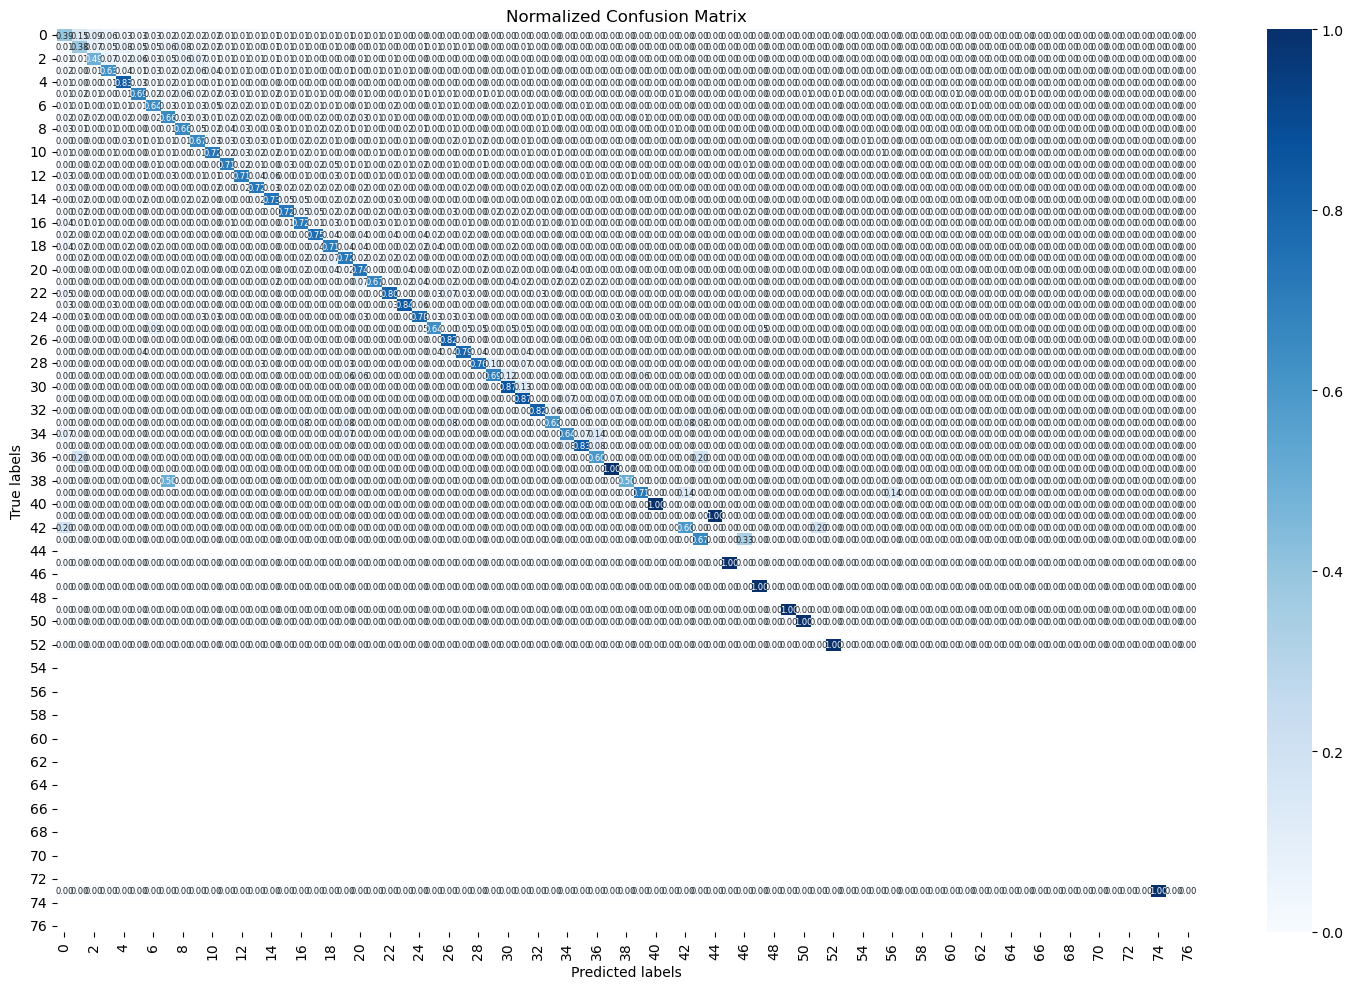

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming flat_true_labels and flat_predictions are already defined

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

# Normalizing the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 10)) # Increased figure size

# Annotate only if the value is significant, e.g., above a threshold
threshold = conf_matrix.max() / 2
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            cbar=True, annot_kws={"size": 6 if conf_matrix.shape[0] > 30 else 10})

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent clipping of tick labels
plt.show()
